# Correlations between Deaths involving COVID-19 and Household Income

In [1]:
import codecs
from IPython.display import HTML, display
display(HTML(codecs.open('covid19.svg', 'r', 'UTF-8').read()))
display(HTML('<img width="600" style="float:left" src="covid19.png">'))

## Project Idea
For my project, I would like to explore factors that affect the COVID-19 death rates in local regions.

Some of these factors are understood, such as age, but I want to bring greater awareness to portions of the population that may not realize that they are at risk based on unexpected criteria.

## Initial Idea: Household Income
This analysis started from my own curiosity. During a national lockdown back in March, I was going to a grocery store for the first time in a week. At a construction site close to where I live, I realized that some people were working, but in unsafe condition without any mask or protective clothing.

Just starting from the plot above showing number of deaths per county, I would like to test whether there is a correlation between COVID-19 and income level, since some people cannot choose to stay home during this pandemic due to financial reasons and must work at the risk of catching a very contagious desease.

Before I move on, I would like to send my deepest condolences and prayers to those who passed away of COVID-19 and their families.

## Data
First, I started by exploring the following public data sets, since income level on an individual level is private:

[CDC Provisional COVID-19 Death Counts in the United States by County](https://data.cdc.gov/NCHS/Provisional-COVID-19-Death-Counts-in-the-United-St/kn79-hsxy): Record of deaths involving COVID-19 for Feb 1st to Jul 25, 2020.

[USDA Economic Research Service Unemployment and median household income for the U.S., States, and counties, 2000-19](https://www.ers.usda.gov/data-products/county-level-data-sets/download-data.aspx): Median household income from the U.S. Census Bureau's Small Area Income and Poverty Estimate (SAIPE) program.

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='serif', serif='Times New Roman')
plt.rcParams['mathtext.fontset'] = 'stix'

In [3]:
COVID = pd.read_csv('Provisional_COVID-19_Death_Counts_in_the_United_States_by_County.csv', \
                    names=['State', 'FIPS', 'COVID-19'], header=0, index_col=1, usecols=[3, 5, 6], \
                    dtype={'State': str, 'FIPS': np.int32, 'COVID-19': np.int32})
COVID

,State,COVID-19
FIPS,,
1001,AL,15
1013,AL,20
1033,AL,13
1039,AL,31
1043,AL,11
1045,AL,13
1047,AL,20
1051,AL,24
1055,AL,24


In [4]:
INC = pd.read_csv('Unemployment.csv', skiprows=[1, 93, 96, 100] + [i for i in range(3197, 3276)], \
                  names=['FIPS', 'State', 'Income'], header=0, index_col=0, usecols=[0, 1, 86], \
                  dtype={'FIPS': np.int32, 'State': str, 'Income': np.int32}, thousands=',')
INC

,State,Income
FIPS,,
1000,AL,49881
1001,AL,59338
1003,AL,57588
1005,AL,34382
1007,AL,46064
1009,AL,50412
1011,AL,29267
1013,AL,37365
1015,AL,45400


In [5]:
INCOME = INC[INC.index % 1000 != 0]

## Assumption
Before going further into this data, for the purpose of this initial investigation, any counties missing data in their COVID-19 Death reports will be counted as zero deaths.

In [6]:
COVID = COVID.reindex(INCOME.index, fill_value=0).assign(State=INCOME['State'])

## Statistics

### Pearson vs. Spearman Correlation Coefficients for the entire United States
A very standard barometer for correlation are the Pearson and Spearman Correlation Coefficients. They should give a rough idea whether this idea has a valid basis.

In [7]:
import scipy.stats

for corr_name in ['pearsonr', 'spearmanr']:
    corr = getattr(scipy.stats, corr_name)
    r, p = corr(INCOME['Income'].subtract(INCOME['Income'].mean()).divide(INCOME['Income'].std(ddof=0)), COVID['COVID-19'])
    print('{} rho = {:.3f}'.format(corr_name.strip('r').title(), r).replace('-', u'\u2212') + \
                                   ' p-value = {:.3f}'.format(p))

Pearson rho = 0.202 p-value = 0.000
Spearman rho = 0.290 p-value = 0.000


In [21]:
SINCOME = INCOME.assign(Income=INCOME['Income'].subtract(INCOME['Income'].mean()).divide(INCOME['Income'].std(ddof=0)))

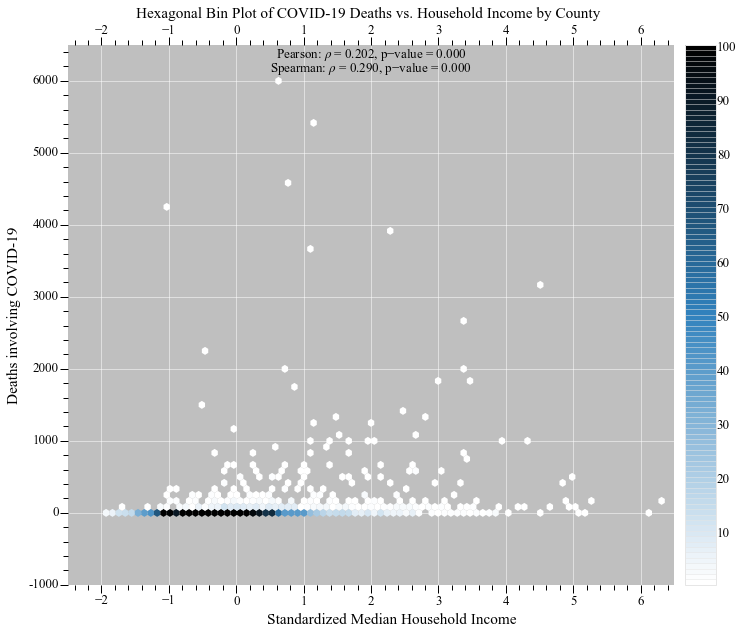

In [8]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

ltrw = 11
ltrh = 8.5
mrgn = 0.1
vmax = 100
ratio = 1000
xbnd = np.array([-2.5, 6.5])
ybnd = np.array([-1000, 6500]) / ratio
ltrw = (xbnd[1] - xbnd[0]) + mrgn * 2
ltrh = (ybnd[1] - ybnd[0]) + mrgn * 2
corr_yloc = {'pearsonr': ybnd[1] - 0.025, 'spearmanr': ybnd[1] - 0.225}

fig = plt.figure(figsize=(ltrw, ltrh))
outer_grid = GridSpec(1, 1, left=mrgn/ltrw, bottom=mrgn/ltrh, right=1-mrgn/ltrw, top=1-mrgn/ltrh, \
                      wspace=1.85/ltrw, hspace=0.1/ltrh)

inner_grid = GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[0], width_ratios=[20, 1], \
                                     wspace=0.32/ltrw)
ax = fig.add_subplot(inner_grid[0])
ax.set_axis_bgcolor('0.95')
cmap = LinearSegmentedColormap.from_list('cmap', [(1, 1, 1), "#3182bd", (0, 0, 0)])
norm = BoundaryNorm(np.arange(0.5, vmax + 1, 1), cmap.N)
hbin = ax.hexbin(SINCOME['Income'], COVID['COVID-19'] / ratio, gridsize=95, mincnt=1, \
                 extent=[min(xbnd[0], ybnd[0]), max(xbnd[1], ybnd[1]), min(xbnd[0], ybnd[0]), \
                         max(xbnd[1], ybnd[1])], cmap=cmap, norm=norm, vmax=vmax, linewidths=0)
for corr_name in corr_yloc:
    corr = getattr(scipy.stats, corr_name)
    r, p = corr(SINCOME['Income'], COVID['COVID-19'])
    ax.text((xbnd[0] + xbnd[1]) * 0.5, corr_yloc[corr_name], \
            r'{}: $\rho$ = {:.3f}'.format(corr_name.strip('r').title(), r).replace('-', u'\u2212') + \
            ', p-value = {:.3f}'.format(p), linespacing=0.675, horizontalalignment='center', \
            verticalalignment='top', fontsize=13)
    if 'son' in corr_name and np.round(p, decimals=3) <= 0.05: ax.set_axis_bgcolor('0.75')
ax.axis([xbnd[0], xbnd[1], ybnd[0], ybnd[1]])
ax.set_axisbelow(True)
ax.grid(True, which='major', color='w', linestyle='-', linewidth=0.5)
ax.tick_params('both', length=8, width=1, which='major', direction='out', labelsize=13)
ax.tick_params('both', length=5, width=1, which='minor', direction='out')
ax.tick_params('x', pad=3)
ax.tick_params('y', pad=-4)
for axis in ['left', 'right', 'top', 'bottom']:
    ax.spines[axis].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xticks(np.arange(np.fix(xbnd[0]), np.floor(xbnd[1]) + 1, 1))
plt.setp(ax.xaxis.get_majorticklabels()[0:2], va='center') 
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_yticks(np.arange(np.fix(ybnd[0]), np.floor(ybnd[1]) + 1, 1))
plt.yticks(ax.get_yticks(), (ax.get_yticks() * ratio).astype(int))
caxes = fig.add_subplot(inner_grid[1])
cbar = plt.colorbar(hbin, cax=caxes, drawedges=True, ticks=np.arange(10, vmax + 1, 10))
cbar.ax.tick_params(length=0, which='both', labelsize=13, pad=1) 
cbar.outline.set_edgecolor('0.9')
cbar.dividers.set_color('0.9')
axs = ax.twiny()

for axis in ['left', 'right', 'top', 'bottom']:
    axs.spines[axis].set_visible(False)
axs.tick_params('both', length=8, width=1, which='major', direction='out', labelsize=13)
axs.tick_params('both', length=5, width=1, which='minor', direction='out')
axs.tick_params('x', pad=-5)
axs.xaxis.set_minor_locator(AutoMinorLocator(5))
axs.set_xticks(np.arange(np.fix(xbnd[0]), np.floor(xbnd[1]) + 1, 1))
axs.set_xlim(xbnd)

fig.text(0.5, -0.05, 'Standardized Median Household Income', \
         horizontalalignment='center', verticalalignment='center', fontsize=15.2)
fig.text(-0.07, 0.5, 'Deaths involving COVID-19', \
         horizontalalignment='center', verticalalignment='center', rotation='vertical', fontsize=15.2)
fig.suptitle('Hexagonal Bin Plot of COVID-19 Deaths vs. Household Income by County', \
             verticalalignment='bottom', x=0.465, y=1.03, fontsize=15.2)
plt.show()

There seems to be a correlation between COVID-19 deaths and median household income since their p-values are zero. If the p-value was greater than 0.05, then it would indicate a weak correlation and the null hypothesis could not be rejected.


### Pearson vs. Spearman Correlation Coefficients for each state except DC and WY

Since Washington, D.C. has one data point and Washington have not reported any cases during the analyzed time period, they are not included in this analysis.

In [9]:
for state in np.setdiff1d(INCOME['State'].unique(), np.array(['DC', 'WY'])):
    print('{}'.format(state))
    for corr_name in ['pearsonr', 'spearmanr']:
        corr = getattr(scipy.stats, corr_name)
        r, p = corr(INCOME[INCOME['State'] == state]['Income'], COVID[COVID['State'] == state]['COVID-19'])
        print('{} rho = {:.3f}'.format(corr_name.strip('r').title(), r).replace('-', u'\u2212') + \
                                       ' p-value = {:.3f}'.format(p))

AK
Pearson rho = 0.247 p-value = 0.196
Spearman rho = 0.271 p-value = 0.155
AL
Pearson rho = 0.268 p-value = 0.028
Spearman rho = 0.465 p-value = 0.000
AR
Pearson rho = 0.379 p-value = 0.001
Spearman rho = 0.334 p-value = 0.003
AZ
Pearson rho = 0.477 p-value = 0.073
Spearman rho = 0.339 p-value = 0.217
CA
Pearson rho = 0.078 p-value = 0.561
Spearman rho = 0.463 p-value = 0.000
CO
Pearson rho = 0.323 p-value = 0.009
Spearman rho = 0.406 p-value = 0.001
CT
Pearson rho = 0.091 p-value = 0.830
Spearman rho = 0.381 p-value = 0.352
DE
Pearson rho = 0.985 p-value = 0.110
Spearman rho = 1.000 p-value = 0.000
FL
Pearson rho = 0.210 p-value = 0.088
Spearman rho = 0.502 p-value = 0.000
GA
Pearson rho = 0.282 p-value = 0.000
Spearman rho = 0.307 p-value = 0.000
HI
Pearson rho = 0.593 p-value = 0.407
Spearman rho = 0.775 p-value = 0.225
IA
Pearson rho = 0.229 p-value = 0.023
Spearman rho = 0.225 p-value = 0.025
ID
Pearson rho = 0.263 p-value = 0.084
Spearman rho = 0.245 p-value = 0.109
IL
Pearson r

The subplots of interest have a darker background with white hexagons of one count for better visibility. These subplots have p-values of Pearson's correlation coefficient that are less than and equal to 0.05. That is, the level of significance is 5% and they are statistically significant.

In [10]:
colors = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#ffffbf','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2']

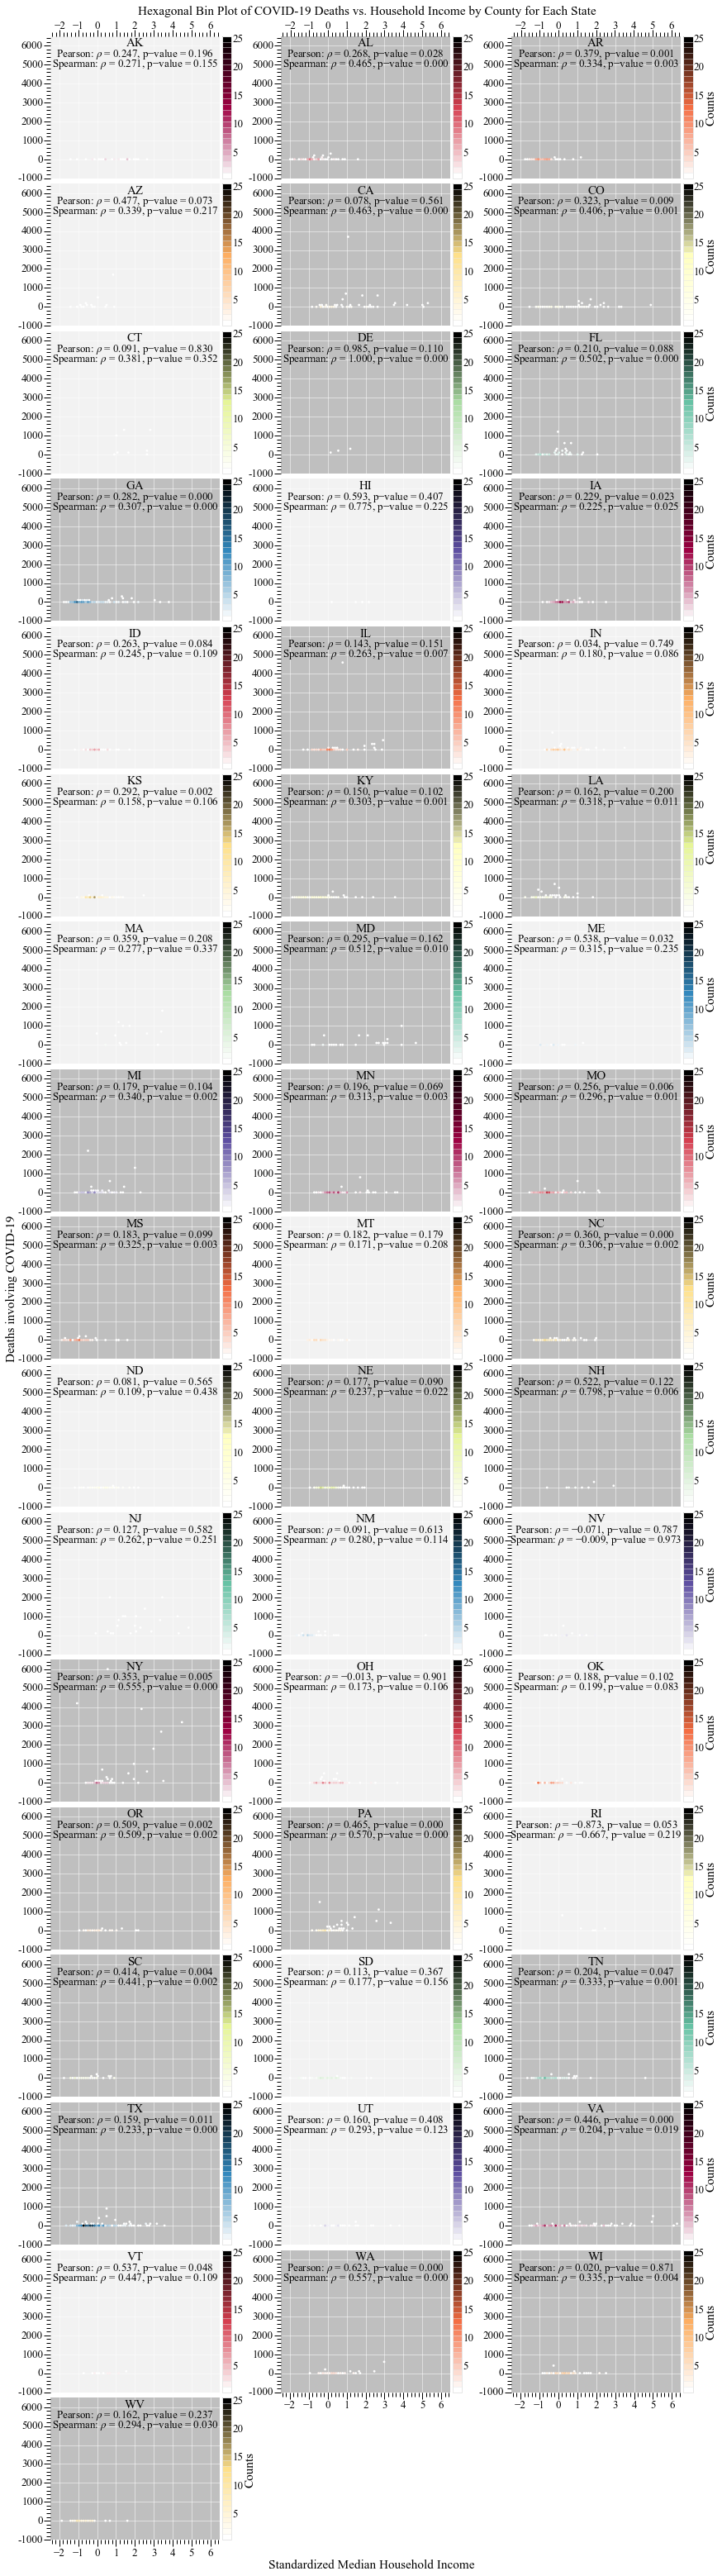

In [50]:
nrnk = len(np.setdiff1d(INCOME['State'].unique(), np.array(['DC', 'WY'])))
inrnk = 6
ncol = 3
nrow = nrnk // ncol if nrnk % ncol == 0 else nrnk // ncol + 1
vmax = 25
ratio = 1000
xbnd = np.array([-2.5, 6.5])
ybnd = np.array([-1000, 6500]) / ratio
ltrw = 11
ltrh = (ybnd[1] - ybnd[0] - 2.55) + mrgn * 2
corr_yloc = {'pearsonr': ybnd[1] - 0.575, 'spearmanr': ybnd[1] - 1.1}

fig = plt.figure(figsize=(ltrw, ltrh / inrnk * ncol * nrow))
outer_grid = GridSpec(nrow, ncol, left=mrgn/ltrw, bottom=mrgn/ltrh, right=1-mrgn/ltrw, top=1-mrgn/ltrh, \
                      wspace=3/ltrw, hspace=0.2/ltrh)

axs = []

for j, state in enumerate(np.setdiff1d(INCOME['State'].unique(), np.array(['DC', 'WY']))):
    inner_grid = GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[j], width_ratios=[18, 1], \
                                         wspace=0.32/ltrw)
    ax = fig.add_subplot(inner_grid[0])
    axs.append(ax.twiny())
    ax.set_axis_bgcolor('0.95')
    cmap = LinearSegmentedColormap.from_list('cmap', [(1, 1, 1), colors[j % 11], (0, 0, 0)])
    norm = BoundaryNorm(np.arange(0.5, vmax + 1, 1), cmap.N)
    hbin = ax.hexbin(SINCOME[INCOME['State'] == state]['Income'], \
                     COVID[COVID['State'] == state]['COVID-19'] / ratio, gridsize=78, mincnt=1, \
                     extent=[min(xbnd[0], ybnd[0]), max(xbnd[1], ybnd[1]), min(xbnd[0], ybnd[0]), \
                             max(xbnd[1], ybnd[1])], cmap=cmap, norm=norm, vmax=vmax, linewidths=0)
    ax.text((xbnd[0] + xbnd[1]) * 0.5, ybnd[1] - 0.025, '{}'.format(state), horizontalalignment='center', \
            verticalalignment='top', fontsize=15)
    for corr_name in corr_yloc:
        corr = getattr(scipy.stats, corr_name)
        r, p = corr(INCOME[INCOME['State'] == state]['Income'], COVID[COVID['State'] == state]['COVID-19'])
        ax.text((xbnd[0] + xbnd[1]) * 0.5, corr_yloc[corr_name], \
                r'{}: $\rho$ = {:.3f}'.format(corr_name.strip('r').title(), r).replace('-', u'\u2212') + \
                ', p-value = {:.3f}'.format(p), linespacing=0.675, horizontalalignment='center', \
                verticalalignment='top', fontsize=13)
        if 'man' in corr_name and np.round(p, decimals=3) <= 0.05: ax.set_axis_bgcolor('0.75')
    ax.axis([xbnd[0], xbnd[1], ybnd[0], ybnd[1]])
    ax.set_aspect('equal')
    ax.set_axisbelow(True)
    ax.grid(True, which='major', color='w', linestyle='-', linewidth=0.5)
    ax.tick_params('both', length=8, width=1, which='major', direction='out', labelsize=13)
    ax.tick_params('both', length=5, width=1, which='minor', direction='out')
    ax.tick_params('x', pad=-3)
    ax.tick_params('y', pad=-4)
    for axis in ['left', 'right', 'top', 'bottom']:
        ax.spines[axis].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    if j > nrnk - ncol - 1: ax.xaxis.set_ticks_position('bottom')
    else: ax.tick_params('x', which='both', bottom='off', labelbottom='off')
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.yticks(ax.get_yticks(), (ax.get_yticks() * ratio).astype(int))
    caxes = fig.add_subplot(inner_grid[1])
    cbar = plt.colorbar(hbin, cax=caxes, drawedges=True, ticks=np.arange(5, vmax + 1, 5))
    cbar.ax.tick_params(length=0, which='both', labelsize=13, pad=1) 
    cbar.outline.set_edgecolor('0.9')
    cbar.dividers.set_color('0.9')
    if j % ncol == 2 or j == nrnk - 1: cbar.set_label('Counts', rotation=90, fontsize=15.2, labelpad=1)

for k, ax in enumerate(axs):
    for axis in ['left', 'right', 'top', 'bottom']:
        ax.spines[axis].set_visible(False)
    ax.tick_params('both', length=8, width=1, which='major', direction='out', labelsize=13)
    ax.tick_params('both', length=5, width=1, which='minor', direction='out')
    ax.tick_params('x', pad=-6)
    if k // ncol != 0: ax.tick_params('x', which='both', top='off', labeltop='off')
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.set_xticks(np.arange(np.fix(xbnd[0]), np.floor(xbnd[1]) + 1, 1))
    ax.set_xlim(xbnd)

fig.text(0.5, 0.01, 'Standardized Median Household Income', \
         horizontalalignment='center', verticalalignment='center', fontsize=15.2)
fig.text(-0.05, 0.5, 'Deaths involving COVID-19', \
         horizontalalignment='center', verticalalignment='center', rotation='vertical', fontsize=15.2)
fig.suptitle('Hexagonal Bin Plot of COVID-19 Deaths vs. Household Income by County for Each State', \
             verticalalignment='bottom', x=0.4925, y=0.988, fontsize=15.2)
plt.show()

In some states, the number of counties was too low to go with the Pearson's correlation coefficient. So I made those plots based on the p-values of the Spearman's correlation coefficients. As shown in the plots, there appears to be significant positive correlation coefficients in 29 states out of 49 states (AL, AR, CA, DE, FL, CO, GA, IA, IL, KY, LA, MD, MI, MN, MO, MS, NC, NE, NH, NY, OR, PA, SC, TN, TX, VA, WA, WI, WV).

## Conclusion
At first, I assumed that people who could not work from home (based on a general assumption that lower income jobs are less available remotely) would be more susceptible to the disease. But after this initial investigation, I have found that there seems to be a very small, however, positive correlation between COVID-19 deaths and median household income.

This is a result I think many people would find unexpected, and I think bears worth further investigation. For example, median income by county may not tell the whole picture. For example, could the income range also have an effect on a county's death rate? I would be interested in finding more hidden factors in these relationships in order to be able to present this to people in an understandable way, and bring a better awareness or consciousness for everyone to be safer in this pandemic.